[View in Colaboratory](https://colab.research.google.com/github/ibacaraujo/generative-image-model/blob/master/generative_image_model.ipynb)

# Generative Image Model

## Progressive GANs

In [0]:
# Install the latest Tensorflow version.
!pip -q install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip -q install tensorflow-hub
# Install imageio for creating animations.  
!pip -q install imageio
!pip -q install scikit-image

In [0]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform

latent_dim = 512

In [0]:
# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)


# Given a set of images, show an animation.
def animate(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  with open('./animation.gif','rb') as f:
      display.display(display.Image(data=f.read(), height=300))


# Simple way to display an image.
def display_image(image):
  plt.figure()
  plt.axis("off")
  plt.imshow(image)


# Display multiple images in the same figure.
def display_images(images, captions=None):
  num_horizontally = 5
  f, axes = plt.subplots(
      len(images) // num_horizontally, num_horizontally, figsize=(20, 20))
  for i in range(len(images)):
    axes[i // num_horizontally, i % num_horizontally].axis("off")
    if captions is not None:
      axes[i // num_horizontally, i % num_horizontally].text(0, -3, captions[i])
    axes[i // num_horizontally, i % num_horizontally].imshow(images[i])
  f.tight_layout()

tf.logging.set_verbosity(tf.logging.ERROR)

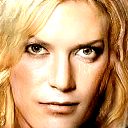

In [6]:
def interpolate_between_vectors():
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")

    # Change the seed to get different random vectors.
    v1 = tf.random_normal([latent_dim], seed=3)
    v2 = tf.random_normal([latent_dim], seed=1)
    
    # Creates a tensor with 50 steps of interpolation between v1 and v2.
    vectors = interpolate_hypersphere(v1, v2, 25)

    # Uses module to generate images from the latent space.
    interpolated_images = module(vectors)

    with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      interpolated_images_out = session.run(interpolated_images)

    animate(interpolated_images_out)

interpolate_between_vectors()

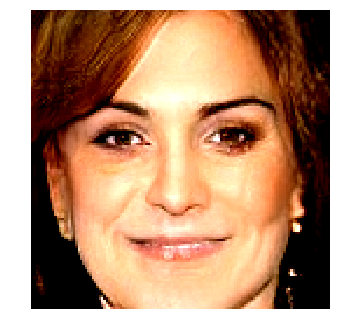

In [7]:
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }

def get_module_space_image():
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")
    vector = tf.random_normal([1, latent_dim], seed=4)
    images = module(vector)

    with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      image_out = session.run(images)[0]
  return image_out

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()
display_image(target_image)

0.68876916
5.607328
5.049135
2.7256722
0.7315385
1.496939
0.8284901
1.1468923
1.4736848
0.7809196
0.8782252
1.2611222
0.8298158
0.51261616
0.76552135
0.28098738
1.0130192
1.3111231
0.95801425
0.17531782
0.38860932
0.22764647
0.20030831
0.38035387
0.14720803
0.82878
0.9529803
0.49972087
0.6415142
0.9430267
0.6892186
0.25421625
0.40336925
0.17275918
0.18559167
0.35673627
0.16563857
0.69867706
0.7976541
0.37081057


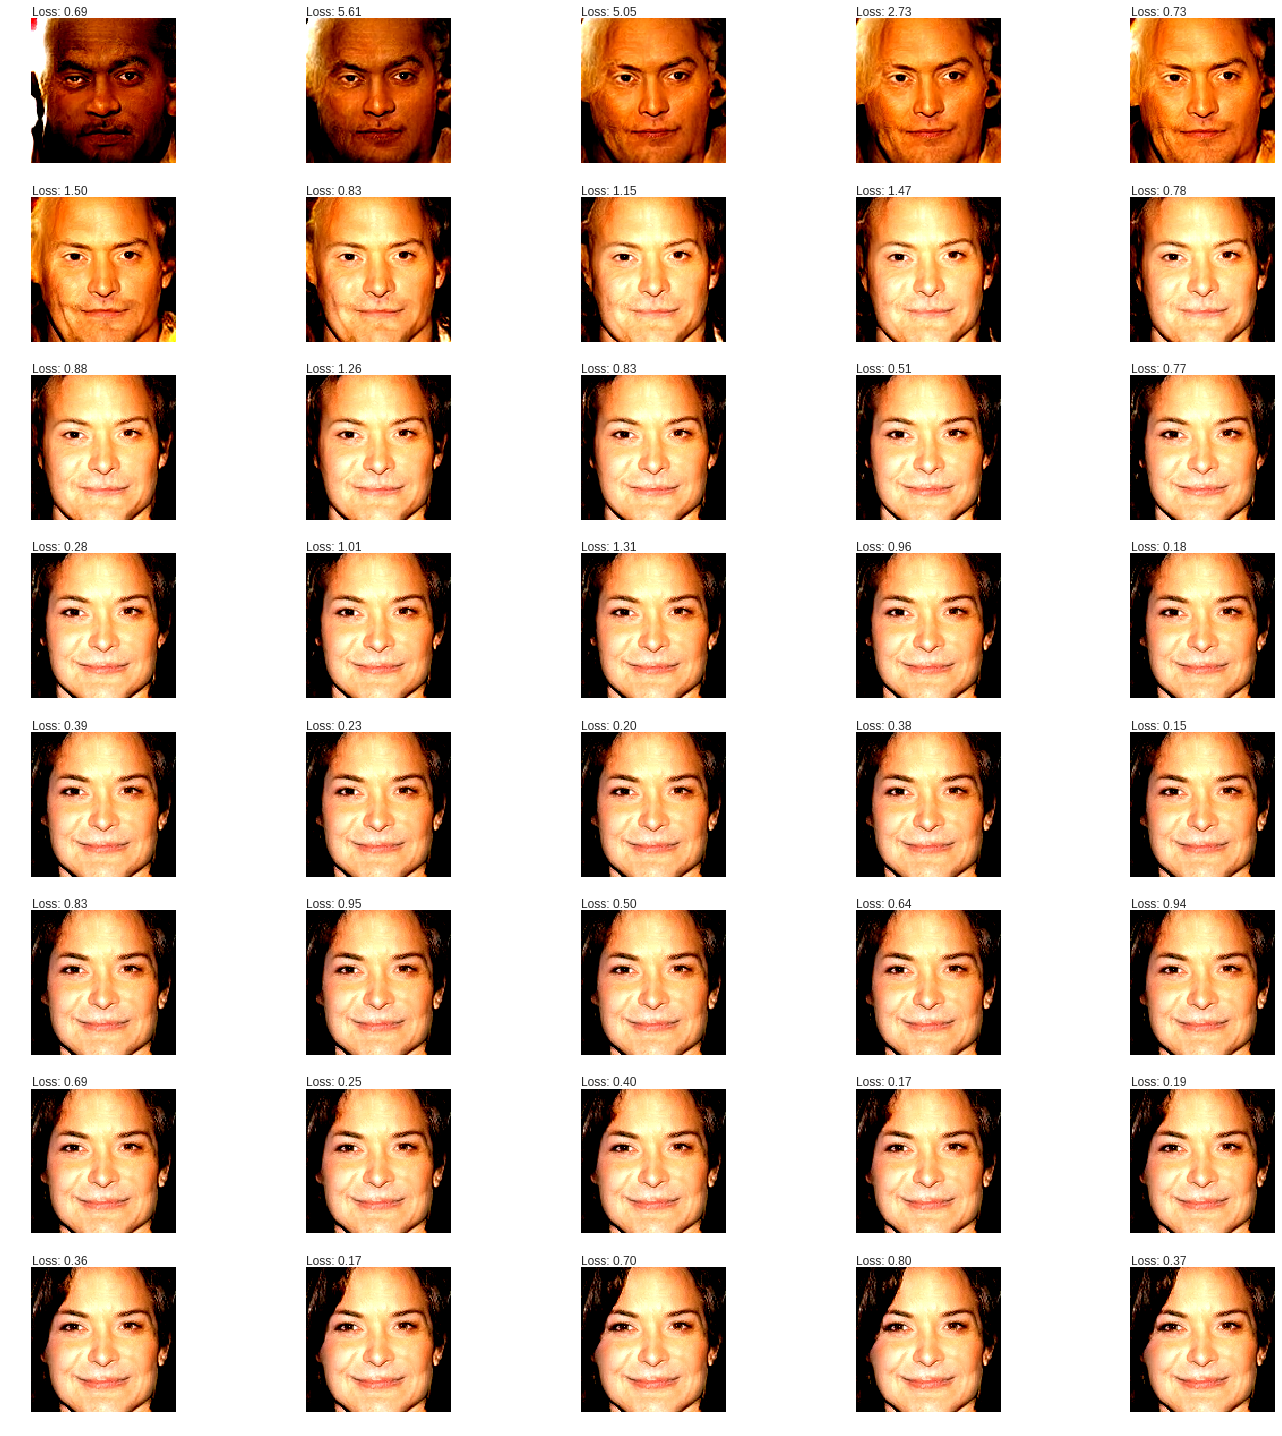

In [8]:
def find_closest_latent_vector(num_optimization_steps):
  images = []
  losses = []
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")

    initial_vector = tf.random_normal([1, latent_dim], seed=5)

    vector = tf.get_variable("vector", initializer=initial_vector)
    image = module(vector)

    target_image_difference = tf.reduce_sum(
        tf.losses.absolute_difference(image[0], target_image[:,:,:3]))

    # The latent vectors were sampled from a normal distribution. We can get
    # more realistic images if we regularize the length of the latent vector to 
    # the average length of vector from this distribution.
    regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))
    
    loss = target_image_difference + regularizer
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.3)
    train = optimizer.minimize(loss)

    with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      for _ in range(num_optimization_steps):
        _, loss_out, im_out = session.run([train, loss, image])
        images.append(im_out[0])
        losses.append(loss_out)
        print(loss_out)
    return images, losses


result = find_closest_latent_vector(num_optimization_steps=40)
display_images(result[0], [("Loss: %.2f" % loss) for loss in result[1]])

## How to make it descend faster and to a more realistic image?